In [ ]:
# # fixes
# pip install -U torch
# pip install -U accelerate
# pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
# pip install xformers

In [1]:
import scipy
import numpy as np
from IPython.display import Audio
import torch

In [2]:
from transformers import pipeline

C:\Users\matve\anaconda3\envs\DMLCP\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Get cpu, gpu or mps device for training.
# See: https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html#creating-models
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [4]:
device

'cuda'

In [54]:
from transformers import AutoProcessor, MusicgenForConditionalGeneration

audioProcessor = AutoProcessor.from_pretrained("facebook/musicgen-small")
audioModel = MusicgenForConditionalGeneration.from_pretrained("facebook/musicgen-small")
audioModel = audioModel.to(device)
sampling_rate = audioModel.config.audio_encoder.sampling_rate

C:\Users\matve\anaconda3\envs\DMLCP\Lib\site-packages\transformers\models\encodec\modeling_encodec.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("padding_total", torch.tensor(kernel_size - stride, dtype=torch.int64), persistent=False)
Config of the text_encoder: <class 'transformers.models.t5.modeling_t5.T5EncoderModel'> is overwritten by shared text_encoder config: T5Config {
  "_name_or_path": "t5-base",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "classifier_dropout": 0.0,
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n

In [98]:
import sys
from pathlib import Path

from PIL import Image
import matplotlib.pyplot as plt


from diffusers import StableDiffusionPipeline
from diffusers import StableDiffusionInpaintPipeline
from diffusers.utils import load_image, make_image_grid

In [120]:
# do inpainting to create face masks for the different gestures
# https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion/inpaint
pipeInPaint = StableDiffusionInpaintPipeline.from_pretrained(
    "stable-diffusion-v1-5/stable-diffusion-inpainting", torch_dtype=torch.float16, safety_checker = None # remove NSFW filter
)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]An error occurred while trying to fetch C:\Users\matve\.cache\huggingface\hub\models--stable-diffusion-v1-5--stable-diffusion-inpainting\snapshots\8a4288a76071f7280aedbdb3253bdb9e9d5d84bb\unet: Error no file named diffusion_pytorch_model.safetensors found in directory C:\Users\matve\.cache\huggingface\hub\models--stable-diffusion-v1-5--stable-diffusion-inpainting\snapshots\8a4288a76071f7280aedbdb3253bdb9e9d5d84bb\unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Loading pipeline components...:  17%|█▋        | 1/6 [00:04<00:20,  4.05s/it]An error occurred while trying to fetch C:\Users\matve\.cache\huggingface\hub\models--stable-diffusion-v1-5--stable-diffusion-inpainting\snapshots\8a4288a76071f7280aedbdb3253bdb9e9d5d84bb\vae: Error no file named diffusion_pytorch_model.safetensors found in directory C:\Users\matve\.cache\huggingface\hub\models--stable-diffusion-v1-5--stabl

In [121]:
pipeInPaint = pipeInPaint.to("cuda");

In [241]:
# Importing Image module from PIL package
from PIL import Image
import PIL

In [300]:
# facemask uvs need to be rotated then rotated back when saved
face_mask = load_image("./masks/faceMask.png").rotate(180).resize((512, 512));
eye_mask = load_image("./masks/eyeMask.png").rotate(180).resize((512, 512));
mouth_mask = load_image("./masks/mouthMask.png").rotate(180).resize((512, 512));




100%|██████████| 50/50 [00:02<00:00, 21.25it/s]


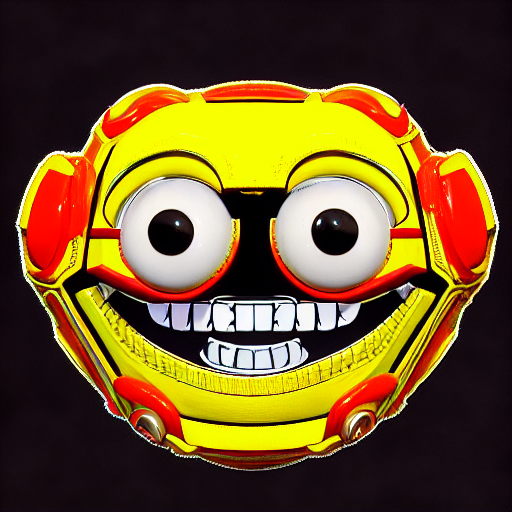

'an expression of smiling happy grinning grin laughing funny joke yellow maximalist, eccentric, colorful, detailed'

100%|██████████| 50/50 [00:02<00:00, 20.38it/s]


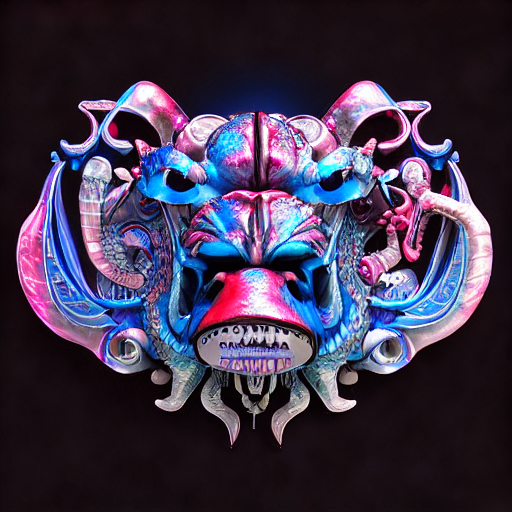

'tears, depressed, tears, blue, crying, sad expression, dramatic, weeping maximalist, eccentric, colorful, detailed'

100%|██████████| 50/50 [00:02<00:00, 20.25it/s]


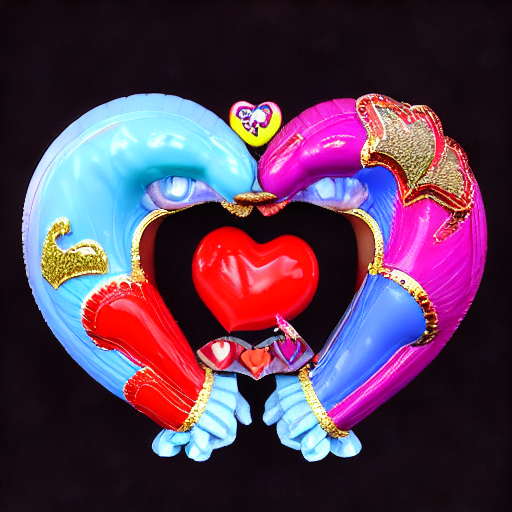

'kissing love hearts red cherub heart, loving, lips maximalist, eccentric, colorful, detailed'

100%|██████████| 50/50 [00:02<00:00, 18.88it/s]


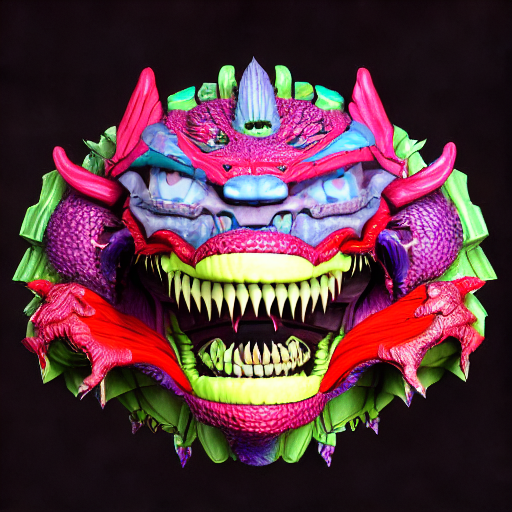

'stern angry maximalist, eccentric, colorful, detailed'

In [382]:
#out = pipe(prompt="texture made out of smiley faces").images[0];
#display(out);

expressionPrompts = ["an expression of smiling happy grinning grin laughing funny joke yellow", 
                     "tears, depressed, tears, blue, crying, sad expression, dramatic, weeping", 
                     "kissing love hearts red cherub heart, loving, lips", 
                     "stern angry"
                    ];
global_negative_prompt = " minimalistic, black-and-white, human"
global_positive_prompt = " maximalist, eccentric, colorful, detailed"

negative_prompts = [
    expressionPrompts[1] + "scary dragon",
    expressionPrompts[0] + "scary feathers controller realistic lips",
    "",
    ""

]

negative_prompts = [ prompt + global_negative_prompt for prompt in negative_prompts];
expressionPrompts = [ prompt + global_positive_prompt for prompt in expressionPrompts];


expressionImages = [];



for expression,negative_prompt in zip(expressionPrompts,negative_prompts):
    out = pipeInPaint(prompt=expression+"eyes pupils irises eyeball" + stylePrompt, 
                      negative_prompt=negative_prompt, 
                      image=eye_mask, 
                      mask_image=eye_mask.filter(PIL.ImageFilter.GaussianBlur(4)),
                      strength = 1.0,
                      guidance_scale=12.5).images[0]
    #display(out);
    out = pipeInPaint(prompt=expression+"mouth teeth" + stylePrompt, 
                      image=out, 
                      negative_prompt=negative_prompt,
                      mask_image=mouth_mask.filter(PIL.ImageFilter.GaussianBlur(4)), 
                      strength = 1.0,
                      guidance_scale=12.5).images[0]
    out = pipeInPaint(prompt=expression+"roccocco 3D Model animatronic monster videogame themepark fantasy" + stylePrompt, 
              image=out,negative_prompt=negative_prompt, 
              mask_image=face_mask, 
              strength = 1.0,
              guidance_scale=12.5).images[0]
    #display(out);

    display(out);
    display(expression)
    expressionImages.append(out);


In [6]:
MODEL_ID = "CompVis/stable-diffusion-v1-4"
# Check out other models by CompVis, different flavours: https://huggingface.co/CompVis
# Runway also has a few: https://huggingface.co/runwayml, for instance "runwayml/stable-diffusion-v1-5"
# or Stability AI (scroll down to models): https://huggingface.co/stabilityai?search_models=stable-diffusion

pipe = StableDiffusionPipeline.from_pretrained(
    MODEL_ID,
    variant="fp16",
    torch_dtype=torch.float16,
    safety_checker = None # remove NSFW filter
).to(device)


Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00, 10.22it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [8]:
class PromptResult():
    def __init__(self):
        self.prompt = None;
        self.result = None;
    
class Room:
    def __init__(self):
        self.textures = {
            "floor": PromptResult(),
            "ceiling": PromptResult(),
            "wall": PromptResult()
        }

        self.icon = PromptResult();
        self.sound = PromptResult();

In [89]:
# from chatgpt4
# Generate a list of 10 themepark themes just names, python list

themepark_themes = [
    "Mythical Realms Adventure",
    "Time Travelers Paradise",
    "Underwater Utopia",
    "Galactic Odyssey",
    "Enchanted Forest Escape",
    "Steampunk City",
    "Pirates and Privateers Cove",
    "Candyland Kingdom",
    "Wild West Frontier",
    "Superhero Metropolis",
    "Dinosaur Dominion",
    "Haunted Hollow",
    "Fantasy Kingdom",
    "Arctic Expedition",
    "Safari Wilderness",
    "Musical Wonderland"
]

# somehow generate multiple themes
# maybe have function to extract theme and expand close words
flatnessPrompt = " 2D, Orthographic Projection, two-dimensional, flat view, flat lay"
stylePrompt = " detailed, intricate, eccentric, maximalist, game, videogame"
logoPrompt = "logo, emblem"
singularityPrompt = "norepeat, one type"

In [91]:
## use data set on pipelines

import os
import glob

# loop over fields generating new rooms
for theme in themepark_themes:
    
    newRoom = Room() 

    path = f'./themes/{theme}';
    texturePath = f'{path}/textures';
    
    if(os.path.isdir(path) == False):
    
        os.mkdir(path);
    
    if(os.path.isdir(texturePath) == False):
        
        os.mkdir(texturePath);
    
        for key in newRoom.textures.keys():
            
            newRoom.textures[key].prompt = f'{key} texture in a {theme} themed themepark' + flatnessPrompt + stylePrompt;
            newRoom.textures[key].result = pipe(newRoom.textures[key].prompt).images[0];
    
            newRoom.textures[key].result.save(f'{texturePath}/{key}.png');
            #display(newRoom.textures[key].result);

        newRoom.icon.prompt = logoPrompt+f'for {theme} themed themepark'+ stylePrompt + singularityPrompt;
        newRoom.icon.result = pipe(newRoom.icon.prompt).images[0];
        newRoom.icon.result.save(f'{texturePath}/icon.png');

print("done generating")


done generating


In [77]:
remove_sounds()

In [139]:
remove_all();

In [138]:
import shutil
import glob

def remove_images():

    themes = glob.glob('./themes/*');
    
    for theme in themes:
        if(os.path.isdir(theme+"/textures") == True):
            shutil.rmtree(theme+"/textures");

def remove_sounds():
    themes = glob.glob('./themes/*');
    
    for theme in themes:
        if(os.path.isdir(theme+"/sounds") == True):
            shutil.rmtree(theme+"/sounds");

def remove_all():
    files = glob.glob('./themes/*')
    for f in files:
        if(os.path.isdir(f)): 
            shutil.rmtree(f);


In [142]:
# 3 minutes

import scipy.io.wavfile
import os
for theme in themepark_themes:
    path = f'./themes/{theme}';
    soundPath = f'./themes/{theme}/sounds'
    
    if(os.path.isdir(path) == False):
        os.mkdir(path);
    if(os.path.isdir(soundPath) == False):
        os.mkdir(soundPath);
        audioInputs = audioProcessor(
            text=[f'loop for a {theme} themed themepark jingle'], # maybe have model convert to music genre or instruments
            padding=True,
            return_tensors="pt",
        )
        audioInputs.to(device)

        audio_values = audioModel.generate(**audioInputs, max_new_tokens=1024) # generate 20 seconds
        print("Generated")
        scipy.io.wavfile.write(f'{soundPath}/{theme}.wav', sampling_rate, np.array(audio_values.cpu().detach().numpy()));
        #Audio(audio_values.cpu()[0], rate=sampling_rate) # figure out way to make it loopable
print("done generating")
        

Generated
Generated
Generated
Generated
Generated
Generated
Generated
Generated
Generated
Generated
Generated
Generated
Generated
Generated
Generated
Generated
done generating


In [143]:
with open('./themes/themes.txt', 'w') as f:
    for theme in themepark_themes:
        f.write(f"{theme}\n")

In [134]:
    themes = glob.glob('./website/themes/*')
    
    for theme in themes:
    
        if(os.path.isdir(theme+"/textures") == True):
            files = glob.glob(theme+"/textures/*")
            for f in files:
                os.rename(f,os.path.relpath(f).replace(os.path.basename(f), "")+os.path.basename(f).replace("texture",""));

        #     shutil.rmtree(theme+"/textures");